In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# R-Calc

The goal of this work is to find an algorithm which can generate resistor networks (up to 4 resistors) with a given equivalent resistance.

## What is this all for?

In high precision measurement elctronic circuits sometimes a specific resistor value is needed. Manufacturers produce resistors within the [E-Series for resistors](https://en.wikipedia.org/wiki/E_series_of_preferred_numbers) of which each value can be multiplied by a factor of $10^{1 \cdots 5}$. If a specific resistor is needed but not present in the E-Series then a wnet of resistors might be used as a replacement for this value.

Calculating the equivalent resistance of a resistor net is an easy task but doing it the opposite way: find a resistor net which matches a given equivalence resistance as close as possible takes a lot of computation. The goal of this project is to find an algorithm which finds the perfect resistor net as fast as possible.

There are two possibilities to combine electrical resistors: In Parallel or in Series. The equivalence resiastance for two resistors $R_1$ and $R_2$ in parallel is calculated the following way:

- Series: $R_1 + R_2$
- Parallel: $\frac{1}{\frac{1}{R_1} + \frac{1}{R_2}} = \frac{R_1 \cdot R_2}{R_1 + R_2}$

Networks with three or more resistors can be created by combining existing networks with each other or with a further resistor using these two operations.

## Available Resistor values:

The Available resistor Values are used from the E96 Series. 

In [2]:
E_96 = np.array([1.00, 1.02, 1.05, 1.07, 1.10, 1.13, 1.15, 1.18, 1.21, 1.24, 1.27, 1.30, 1.33, 1.37, 1.40, 1.43, 1.47, 1.50, 1.54, 1.58, 1.62, 1.65, 1.69, 1.74, 1.78, 1.82, 1.87, 1.91, 1.96, 2.00, 2.05, 2.10, 2.15, 2.21, 2.26, 2.32, 2.37, 2.43, 2.49, 2.55, 2.61, 2.67, 2.74, 2.80, 2.87, 2.94, 3.01, 3.09, 3.16, 3.24, 3.32, 3.40, 3.48, 3.57, 3.65, 3.74, 3.83, 3.92, 4.02, 4.12, 4.22, 4.32, 4.42, 4.53, 4.64, 4.75, 4.87, 4.99, 5.11, 5.23, 5.36, 5.49, 5.62, 5.76, 5.90, 6.04, 6.19, 6.34, 6.49, 6.65, 6.81, 6.98, 7.15, 7.32, 7.50, 7.68, 7.87, 8.06, 8.25, 8.45, 8.66, 8.87, 9.09, 9.31, 9.53, 9.76])
R_Values = np.array([10**i * E_96 for i in range(1,6)]).flatten()

These are the resistor values on which all further operations will be trested. There are differend E-Series (E3, E6, E12, E24, E48 and E192) but the algorithm should work the same on them so there is no need to perforem the proof of concept method on them.

## Nets with two resistors

Let's simply calculate all the solutions for nets with two resistors. First of all we are going to define out two combinatoral operations:

In [3]:
def row(r1, r2): return r1 + r2
def parallel(r1, r2): return (r1 * r2)/(r1 + r2)

For the calculation of the parallel resistor values the equation was modified for the sake of a faster execution. This comes from the side effect that calculating a sum or a multiplication can be done way faster within the CPU than calculating the multiplicative inverse $\frac{1}{x}$. A simple [Speedtest](./parallel_speed_test/speedtest.cpp) written in C++ has prooven this behavior and shows that the improved version is approximately 3 times faster.

The following code segment also depicts this behavior in python where the execution is bottlenecked by the interpreter and therefore the difference is not as dramatic as in the C++ benchmark:

In [4]:
# for performance reasons the number fo iterations is set to 1
%timeit -r1 [[1 / ((1 / i) + (1 / j)) for j in R_Values] for i in R_Values]
%timeit -r1 [[(i * j) / (i + j) for j in R_Values] for i in R_Values]

149 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
123 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


At first we can calculate all the possible combinations of two resistors. Before that lets take a closer look at the calculation of the resistor values: They are both combined with an addition which is a symmetrical operation: $A + B = B + A$. This means that each combination is represendet twice in the matrix. Thefollowing figures are plots of the computed dataset which contains all combinations and the red line shows the symmetry axis. This plot is logarithmic because otherwise the change in the values would be so rapid to the end that for most of the matrix the colour would be the same and the symmetry would be hard to notice.

/tmp/ipykernel_3437084/2532696447.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.matshow(np.log(R2_Series), cmap=plt.cm.get_cmap('gray_r', 100))
/tmp/ipykernel_3437084/2532696447.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.matshow(np.log(R2_Parallel), cmap=plt.cm.get_cmap('gray_r', 100))


Text(0.5, 1.0, 'Values of two resistors in parallel')

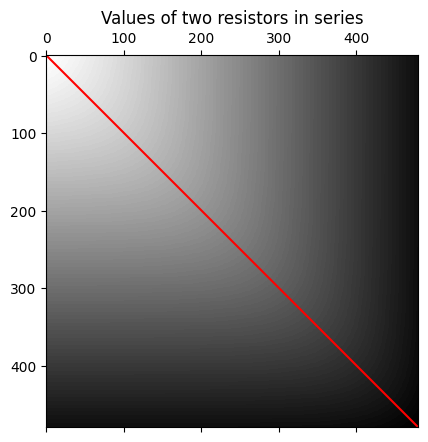

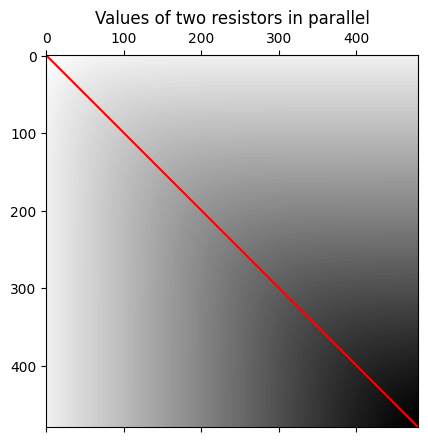

In [52]:
R2_Series = [[row(i, j) for j in R_Values] for i in R_Values]
plt.matshow(np.log(R2_Series), cmap=plt.cm.get_cmap('gray_r', 100))
plt.plot([0, len(R2_Series) - 1], [0, len(R2_Series) - 1], color='red')
plt.title("Values of two resistors in series")

R2_Parallel = [[parallel(i, j) for j in R_Values] for i in R_Values]
plt.matshow(np.log(R2_Parallel), cmap=plt.cm.get_cmap('gray_r', 100))
plt.plot([0, len(R2_Parallel) - 1], [0, len(R2_Parallel) - 1], color='red')
plt.title("Values of two resistors in parallel")

In this case the position of the symmetry line can be used as a benefit: Only a triangular fraction of the matrix needs to be computed and stored. But which fraction in detail?

Let's say that the dataset is a two dimmensional matrix where the values can be accessed by the indices `matrix[i][j]`. The first axis (`i`) i the vertial axis in the pictures above and covers all the resistors in the table `R_Values`. Therefore the index `i` covers all index values from `0` to `len(R_Values)`. For the horizontal axis which will be represented by the index `y` in the dataset matrix, the index range (for the list `R_Values`) is depending on the index `i` for each row: the index covers all numbers from `0` to `<=i`. With this knowledge the boundaries for the region of interest are defined.

Another interesting aspect of this matrix lies in the gradient of this matrix. The derivatives of $R_1 + R_2$ and $\frac{R_1 \cdot R_2}{R_1 + R_2}$ are always positive. This implies that the gradient also is always positive and will always point to the maximum value in the matrix: the combination of the highest resistor value with itself (lower right corner in the table).

/tmp/ipykernel_3437084/2731724453.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.matshow(A, cmap=plt.cm.get_cmap('gray_r', 100))


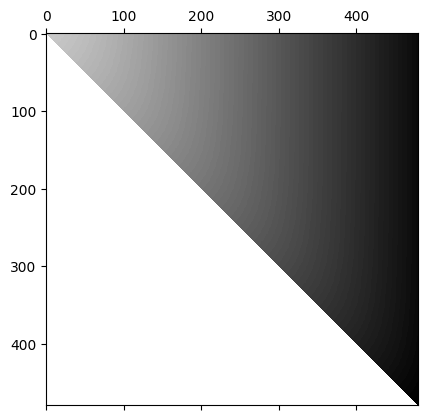

In [50]:
A = np.triu(np.log(R2_Series))
plt.matshow(A, cmap=plt.cm.get_cmap('gray_r', 100))

TODO: Explain why the gradient of this matrix is {{streng monoton}}